# Python assignment

The python assignment you can do either on your own or with one other student (i.e. max group size is 2 students).

The first cell of your notebook, should contain a table with the names and ANRs of the group members, like so

|Name|Anr.|
|----|-------|
|Marco Alberti|u922225|
|Filippo Alberton|u902215|


#  A path through world inequality                                            

## Table of contents
1. [Introduction](#introduction)
2. [The Gini coefficient](#Gini)
    1. [Introduction to the index](#Gini_1)
    2. [Time trends](#Gini_2)
3. [The Theil Index](#Theil)
    1. [Introduction to the index](#Theil_1)
    2. [Time trends](#Theil_2) 
4. [The MLD](#MLD)
    1. [Introduction to the index](#MLD)
    2. [Time trends](#MLD)  
5. [Interactive distribution graph](#IDG)
6. [Conclusions](#Conc)

## Introduction <a name="introduction"></a>

Income inequality is perceived as one of the main determinants of social injustice. Although in the last century the world has seen an [exponetial growth](#the_destination) as never experienced before in the human history, the benefits of the GDP growth have not been equally distributed across population groups.
This divergency in top vs bottom incomes has made many economists, see for instance the work of [E.Saez](https://eml.berkeley.edu/~saez/) or [T.Piketty](http://piketty.pse.ens.fr/fr/), questioning whether the current scheme of growth is sustainable in the long run. 
But income inequality is not a topic to confine into technical studies and between the libraries shelves. Its echo also reached the public debate, and [numerous articles](https://www.economist.com/topics/economic-inequality) started to pop up in many well-known journals along with magic receipts to tackle the problem. Why should I be interested I hear you whispering ?
Well, inequality comes to a price that our societies as an whole have to pay. In fact, not only it appears to have a negative effect on the [growth](https://www.economist.com/the-economist-explains/2015/06/15/how-inequality-affects-growth) itself, but it also affects how [secure the streets](https://www.economist.com/graphic-detail/2018/06/07/the-stark-relationship-between-income-inequality-and-crime) are. 
Not yet convinced? In what follows we will investigate income inequality at World's regional level using different methods and displaying the results in user friendly graphs.

In [1]:
%%html
<a id='the_destination'></a>
<iframe src="https://data.worldbank.org/share/widget?indicators=NY.GDP.MKTP.CD" width='900' height='600' 
frameBorder='0' scrolling="no" >
</iframe>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import scipy
from scipy.interpolate import interp1d
from scipy import integrate
plt.style.use('seaborn')

%matplotlib inline

We downloaded a dataset from the [World Inequality Database](https://wid.world/) that contains data on income distribution from the year 1980 to 2016 for seven different world regions: Asia, Europe, Latin America, Us-Canada, Middle-East, Russia and Sub-Saharian Africa.

In [3]:
World = pd.read_csv('data/Regions.csv')
World.rename(columns={'Income group (percentile)': 'Percentile'}, inplace=True)
World.head()

,Region,Year,Percentile,Average national income per adult,Bracket average,Bracket share,Income threshold,Bottom share,Top share
0,Asia,1980,0.0,3959.364857,62.448406,0.000158,0.000000,0.000158,1.000000
1,Asia,1980,1.0,3959.364857,178.881831,0.000452,121.665563,0.000610,0.999842
2,Asia,1980,2.0,3959.364857,250.138455,0.000632,227.338935,0.001241,0.999390
3,Asia,1980,3.0,3959.364857,329.719705,0.000833,292.441127,0.002074,0.998759
4,Asia,1980,4.0,3959.364857,412.463226,0.001042,373.840612,0.003116,0.997926


In [4]:
 # We are interested in the one hundred percentiles of the income distribution so we will exclude from the dataframe the highest percentile from 99,1 to 99,999
World.drop(World[World.Percentile > 99.00].index, inplace = True)
World.reset_index(drop = True, inplace = True)
World.head()

 # For the following parts we are going to work with this new dataframe, therefore we will save it in format csv on the russet 
World.to_csv('data/World.csv', index = False)



## The Gini coefficient  <a name="Gini"></a>

### Introduction to the index <a name="Gini_1"></a>

One of the most famous and used measurement of inequality is the Gini coefficient: developed in 1912 by Italian statistician [Corrado Gini](https://en.wikipedia.org/wiki/Corrado_Gini), it compares the distribution of income in a certain region with an baseline situation in which every citizen earn the same amount. A coefficient of 1 indicates maximum inequality (i.e. a situation in which the 100% of national income is earned by a single individual) while a coefficient of 0 represent perfect equality. Nevertheless the interpreatation of this coefficient can be problematic: firstly, it fails to capture welfare and social benefits that could help to reduce the gap between citizens; secondly, different distributions could result in the same Gini Index; lastly, the demographic structure of a country is not taken into consideration.

#### This index can be calculated as follow:

For a population of$\ n$ persons where $x_i$ is the income of person $i$



$ \mspace{350mu}\Large G = \frac{\sum_{i=1}^{n}\sum_{j=1}^{n} |x_{i} - x_{j}|}{2n\sum_{i=1}^{n} x_{i}}  $

For a population with values $x_i$, with $ i$ that goes from $1$ to $n$, that are indexed in non-decreasing order ( $x_i ≤ x_{i+1} $) an alternative expression is:

$ \mspace{280mu}\Large G =\frac{1}{n}\Bigg(n+1-2\Bigg(\frac{\sum_{i=1}^{n}(n+1-{i})x_{i}}{\sum_{i=1}^{n} x_{i}}\Bigg)\Bigg) $


We are going to use this second expression in order to derive the Gini coefficient for the region in our dataset. 
But firstly we would like to start by showing how the Gini Index can be defined mathematically by mapping the  [Lorenz curve](https://en.wikipedia.org/wiki/Lorenz_curve) and the perfect distribution line.The former is created starting from our income distribution data while latter is a $ 45^\circ$ degree line.


In the next cells the lorenze curve for Europe and Africa in the Year 2016 will be presented.

In [5]:
 # From our dataset we want to isolate the income of the 100 percentiles of Europe and Africa in the year 2016
Europe_2016 = World[(World.Region == 'Europe') & (World.Year == 2016)]
Africa_2016 = World[(World.Region == 'Sub-Saharian Africa') & (World.Year == 2016)]

 # The Lorenz curve shows for each percentile of our distriburion the comulative share of income earned.
 # To do this we use the functions cumsum and sum.
lorenz_Europe = Europe_2016['Bracket average'].cumsum() / Europe_2016['Bracket average'].sum()
lorenz_Africa = Africa_2016['Bracket average'].cumsum() / Africa_2016['Bracket average'].sum()

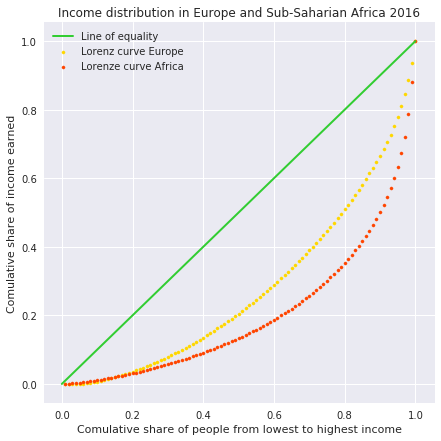

In [6]:
plt.figure(figsize=(7,7))
range_x = np.arange(0.01,1.01,0.01)

 # line plot of equality
plt.plot([0,1] , [0,1], color='limegreen', linewidth=2)

 # scatter plot of Lorenz curve
plt.scatter(range_x, lorenz_Europe,  color='gold', s=10)
plt.scatter(range_x, lorenz_Africa, color='orangered', s=10)

plt.xlabel('Comulative share of people from lowest to highest income')
plt.ylabel('Comulative share of income earned')
plt.title('Income distribution in Europe and Sub-Saharian Africa 2016')
plt.legend(('Line of equality', 'Lorenz curve Europe', 'Lorenze curve Africa'))
plt.show()

As stated before the Gini index can be calculated starting from the Lorenz curve. What we need is a function for it and, since we only have some datapoint, we are going to extrapolate a quadratic function from them.

In [7]:
 # This is the formula for the lorenz curve that we can see above
l = interp1d(range_x, lorenz_Europe, kind = 'quadratic') 
 # Now we integrate the lorenz curve to determine the area below the curve
B = scipy.integrate.quad(l,0.01,1)  


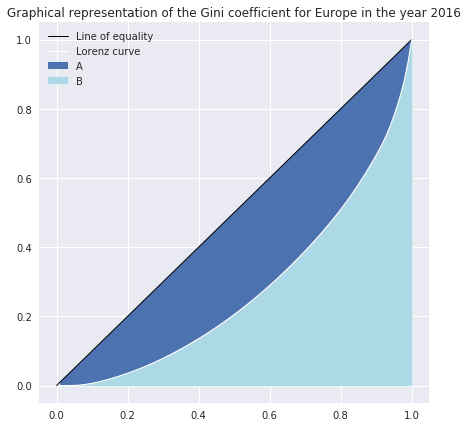

In [8]:
plt.figure(figsize=(7,7))

 # Line of perfect equality
plt.plot([0,1], [0,1], color='black', linewidth=1)

 # Lorenz curve
plt.plot(range_x, lorenz_Europe,  color='white', linewidth = 1)

 # We want to fill area between these two curve and the area below the Lorenz curve
plt.fill_between(range_x,lorenz_Europe, [x for x in range_x],label = 'A')
plt.fill_between(range_x,lorenz_Europe,  color = 'lightblue', label = 'B' )

plt.title('Graphical representation of the Gini coefficient for Europe in the year 2016')
plt.legend(('Line of equality', 'Lorenz curve','A','B'))
plt.show()

In the graph above the Gini coefficient can be seen as the ratio between the area $ \large A$ and the area of the triangle below the line of equality:

$ \mspace{350mu}\large G = \frac{A}{A + B}  $ 

Closer the Lorenz curve is to the $ 45^\circ$ degree line lower the Gini coefficient will be. Alternatively the index can be seen as:

$ \mspace{350mu}\large G = 1 - 2B $  

Those two method should be equivalent since the area of $ A + B = 0.5 $

In [9]:
A = 0.5 - B[0]      # where 0.5 is the area of the triangle

Method_1 =   1-2*B[0] 
Method_1
Method_2 = A / (A + B[0])
Method_1 == Method_2

True

Now we want to calculate the gini index for each region and for each year starting from our dataframe. Firstly we will define a function that, given an array, can return the Gini Index for that group of values. 

In [10]:
def gini(array): 
    n = array.size
    
    # for the summation we will use the function enumerate that loop over each value of the array and, at the same time,has an automatic counter
    numerator = sum([(n+1-i)*yi for i, yi in enumerate(array)]) 
    
    return (1/n)*(n+1-2*(numerator/array.sum())) 
    

In [11]:
 # As stated before, to calculate the value of the index we need to split the dataframe in an array with chunk of the same size of the number of percentiles (100)

k = 100  # chunk row size
World_arr = np.asarray([World['Bracket average'][i:i+k] for i in range(0,World['Bracket average'].shape[0],k)])

In [12]:
Gini_list = []     # we inizialyze an empty list  
for i in range(0,len(World_arr)):     # then, for each chunk of world_arr
    Gini_list.append(gini(World_arr[i]))     # we pass the function Gini and we append it to Gini_list
       
Gini_index = [ i for i in Gini_list for r in range(k) ] # to add a column in our original dataframe we need to  
World['Gini'] = Gini_index     # we add the Index as a column in the dataframe

### Plotting the time trend  <a name="Gini_2"></a>

In what follows we are going to plot, for each of our world regions, the evolution of the Gini coefficient in the period 1980-2016 in order to see whether the distribution of income has become more or less equal

In [13]:
df_summary = World[['Region','Year', 'Gini']].drop_duplicates()     # here we create a new dataframe that displays, for each region and for each year, the value of our indexes
df_summary.reset_index(drop = True, inplace = True)
formatted=['{:0.4f}'.format(i) for i in df_summary['Gini']]      # we format our values in order to have 4 decimals
df_summary['Gini']=formatted
df_summary.head()

,Region,Year,Gini
0,Asia,1980,0.5196
1,Asia,1981,0.5156
2,Asia,1982,0.5134
3,Asia,1983,0.5140
4,Asia,1984,0.4970


In [14]:
 # we import the visualization library bokeh in order to create an interactive graph
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource, ColorBar, CDSView, GroupFilter


In [15]:
output_notebook()

 # To plot the time trend for each region we need to create a dataframefor each different country 
Asia_data = df_summary[df_summary['Region'] == 'Asia']
Europe_data = df_summary[df_summary['Region'] == 'Europe']
LatinAmerica_data = df_summary[df_summary['Region'] == 'Latin America']
MiddleEast_data = df_summary[df_summary['Region'] == 'Middle East']
Russia_data = df_summary[df_summary['Region'] == 'Russia']
SubSaharianAfrica_data = df_summary[df_summary['Region'] == 'Sub-Saharian Africa']
USCanada_data = df_summary[df_summary['Region'] == 'US-Canada']

Asia_cds = ColumnDataSource(Asia_data)  
Europe_cds = ColumnDataSource(Europe_data)
LatinAmerica_cds = ColumnDataSource(LatinAmerica_data)
MiddleEast_cds = ColumnDataSource(MiddleEast_data)
Russia_cds = ColumnDataSource(Russia_data)
Africa_cds = ColumnDataSource(SubSaharianAfrica_data)
USCanada_cds = ColumnDataSource(USCanada_data)

 # to create an interactive plot we use Hovertool and we tell python to use the dataframe columns Year, Gini and Region
hover = HoverTool(tooltips=[  
     ('Year','@Year'),
     ('Gini','@Gini'),
     ('Region', '@Region')
     ])

p = figure(title="Gini index 1980-2016", y_axis_type="linear",
           tools = [hover], plot_width = 800)
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Gini Index'

 # we plot a line of the Gini coefficient and we repeat it for each region
p.line('Year', 'Gini', source = Asia_cds, color = 'yellow', legend='Asia',line_width=3 )
p.line('Year', 'Gini', source = Europe_cds, color = 'lawngreen', legend='Europe',line_width=3 )
p.line('Year', 'Gini', source = LatinAmerica_cds, color = 'seagreen', legend='Latin America', line_width=3 )
p.line('Year', 'Gini', source = MiddleEast_cds, color = 'deepskyblue', legend='Middle East', line_width=3 )
p.line('Year', 'Gini', source = Russia_cds, color = 'red', legend='Russia', line_width=3 )
p.line('Year', 'Gini', source = Africa_cds, color = 'deeppink', legend='Sub-Saharian Africa',line_width=3  )
p.line('Year', 'Gini', source = USCanada_cds, color = 'blue', legend='Us-Canada',line_width=3 )

p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.title.text_font_size = '25pt'
p.legend.location = "bottom_right"

show(p)

Loading BokehJS ...

Looking at the graph, is straightforward to see that Middle East and Africa are the most unequal regions, while among the others Europe is consistently the most equal region since 1993. 
For what regards time trends, inequality is increasing consistently in Us-Canada and Asia. On the contrary,the Theil index is diminishing for Middle East and Africa in particular starting from the 90s.
A peculiar case is represented by Russia. In fact, the black line shows a sharp increase in inequality around the early 90's. Apperently the Soviet system was a main determinant of the incredibly equal society during the 80's. After the U.R.S.S. collapse, the Theil index skyrocket almost reaching the peak level of the afore mentioned high inequality regions. 

## Theil T index  <a name="Theil"></a>

### Introduction to the index <a name="Theil_1"></a>

The Theil Index can be seen as a measure of redundancy, lack of diversity, isolation, segregation, inequality, non-randomness. Originally used in information theory to measure the entropy of the data provided, nowdays is one of the primary indexes to measure inequality in a population (for further information click [here](https://en.wikipedia.org/wiki/Theil_index)). 
The main reason for it's popularity is the so called 'additive decomposability' property. This implies that the index for the general population can be decomposed in two additive parts, one representing the inequality betweeen m subgroups, and the other representing inequality within each subgroup. Isn't this an useful property?
Just think about it, imagine we are computing Theil index for the United States. Thanks to this property we would be able to investigate the marginal contribution of each State to the general inequality, expressed as the weighted average inequality within states plus the inequality between states.
In this section we will compute and explore the Theil Index for the seven Regions in the dataframe and for the entire period 1980-2016. After presenting our results in an interactive graph, we will discuss regional differences, time trends and notable insights.

First, we will compute the $\textbf{Theil T index}$ defined as: 

$\mspace{350mu}\Large\frac{1}{N}\cdot\sum\limits_{i=1}^N \frac{x_i}{\mu} \cdot \ln (\frac{x_i}{\mu})$

Where:
$\qquad\textbf{N}$=number of individuals
$\qquad x_i$=income of individual i
$\qquad\mu$=average income

As can be derived by its definition, the index range from 0 in case of perfect equality, to $\ln(N)$ in case of total inequality, meaning that one person owns all the existing income. 

In [16]:
def theil_T(x):
    n = len(x)
    mu=sum(x)/(float(len(x))) #computing the mean income
    summ=sum([((i/mu)*math.log(i/mu)) for i in x if i>=1]) #computing the body of the index through a list comprehension
    return (1/n)*summ

Having defined a function that computes the *Theil T* index over a given list of elements, we now pass as argument the column of the dataset 'Bracket average', taking the average income of each percentile as a single observation. We repeat this procedure using a for loop, computing the index on 100 entries each time until the entire file has been read. Since the dataset is sorted by region and year, we will get in one line the *Theil T* index for each region and year.  We initialize and fill a list of the indexes obtained.

In [17]:
indexes=[]
for chunk in pd.read_csv('data/World.csv',chunksize=100): #passing the theil function on chunks of the dataset
    indexes.append(theil_T(chunk['Bracket average']))
len(indexes)    

259

Now indexes is a list with 37 years x 7 regions =259 entries.

In [18]:
theilT_index = [ i for i in indexes for r in range(100) ] #expand the 'indexes' list assigning the same value to each percentile
World['Theil T Index'] = theilT_index #append the Theil index column to the World dataframe

In [19]:
World.head()

,Region,Year,Percentile,Average national income per adult,Bracket average,Bracket share,Income threshold,Bottom share,Top share,Gini,Theil T Index
0,Asia,1980,0.0,3959.364857,62.448406,0.000158,0.000000,0.000158,1.000000,0.51961,0.511296
1,Asia,1980,1.0,3959.364857,178.881831,0.000452,121.665563,0.000610,0.999842,0.51961,0.511296
2,Asia,1980,2.0,3959.364857,250.138455,0.000632,227.338935,0.001241,0.999390,0.51961,0.511296
3,Asia,1980,3.0,3959.364857,329.719705,0.000833,292.441127,0.002074,0.998759,0.51961,0.511296
4,Asia,1980,4.0,3959.364857,412.463226,0.001042,373.840612,0.003116,0.997926,0.51961,0.511296


Now the *World* dataframe has a new column named *Theil T*. 
In order to easily compute the descriptive statistics and draw the graphs, we append our indexes' list to the previously created *df_summary* dataframe. 

In [20]:
df_summary['Theil'] = indexes
df_summary.reset_index(drop = True, inplace = True)
formatted=['{:0.4f}'.format(i) for i in df_summary['Theil']] #format the Theil index
df_summary['Theil']=formatted #append the formatted index to the summary dataframe

df_summary.head()

,Region,Year,Gini,Theil
0,Asia,1980,0.5196,0.5113
1,Asia,1981,0.5156,0.5027
2,Asia,1982,0.5134,0.4976
3,Asia,1983,0.5140,0.5003
4,Asia,1984,0.4970,0.4658


### Plotting the time trend  <a name="Theil_2"></a>

In what follows we create an interactive graph using Bokeh. The graph will plot the Theil T index for the seven regions over the dataset timeline. In this way we will be able to investigate at once both regional differences and time trends. 

In [29]:
output_notebook()

Asia_data = df_summary[df_summary['Region'] == 'Asia']
Europe_data = df_summary[df_summary['Region'] == 'Europe']
LatinAmerica_data = df_summary[df_summary['Region'] == 'Latin America']
MiddleEast_data = df_summary[df_summary['Region'] == 'Middle East']
Russia_data = df_summary[df_summary['Region'] == 'Russia']
SubSaharianAfrica_data = df_summary[df_summary['Region'] == 'Sub-Saharian Africa']
USCanada_data = df_summary[df_summary['Region'] == 'US-Canada']

Asia_cds = ColumnDataSource(Asia_data)  
Europe_cds = ColumnDataSource(Europe_data)
LatinAmerica_cds = ColumnDataSource(LatinAmerica_data)
MiddleEast_cds = ColumnDataSource(MiddleEast_data)
Russia_cds = ColumnDataSource(Russia_data)
Africa_cds = ColumnDataSource(SubSaharianAfrica_data)
USCanada_cds = ColumnDataSource(USCanada_data)

hover = HoverTool(tooltips=[
     ('Year','@Year'),
     ('Theil','@Theil'),
     ('Region', '@Region')])

p = figure(title="Theil T index 1980-2016", y_axis_type="linear",
           tools = [hover], plot_width = 800)
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Theil T Index'

p.line('Year', 'Theil', source = Asia_cds, color = 'yellow', legend='Asia',line_width=3)
p.line('Year', 'Theil', source = Europe_cds, color = 'lawngreen', legend='Europe',line_width=3)
p.line('Year', 'Theil', source = LatinAmerica_cds, color = 'seagreen', legend='Latin America',line_width=3)
p.line('Year', 'Theil', source = MiddleEast_cds, color = 'deepskyblue', legend='Middle East',line_width=3)
p.line('Year', 'Theil', source = Russia_cds, color = 'red', legend='Russia',line_width=3)
p.line('Year', 'Theil', source = Africa_cds, color = 'deeppink', legend='Africa',line_width=3)
p.line('Year', 'Theil', source = USCanada_cds, color = 'blue', legend='Us-Canada',line_width=3)

p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.title.text_font_size = '25pt'
p.legend.location = "bottom_right"

show(p)

Loading BokehJS ...

## Mean Log deviation <a name="MLD"></a>

### Introduction to the index <a name="MLD_1"></a>

$\mspace{350mu}\Large\frac{1}{N}\cdot\sum\limits_{i=1}^N \ln (\frac{\mu}{x_i})$

The mean log deviation(MLD) is a measure of inequality representing a special case of the generalized entropy index of which also the Theil T index belongs. MLD ranges between 0, in case of perfect equality, and large positive values. The main peculiarity of this measure is that it's more sensitive to differences at the lower end of the distribution, meaning that income gaps at the bottom of the distribution are weighted more than differences at the top end.

In [22]:
def MLD(x):
    n = len(x)
    mu=sum(x)/(float(len(x))) #computing the mean of income
    summ=sum([(math.log(mu/i)) for i in x if i>0]) #computing the body of the index through a list comprehension
    return (1/n)*summ 

In [23]:
indexes_2=[]
for chunk in pd.read_csv('data/World.csv',chunksize=100): #passing the MLD function on chunks of the dataset
    indexes_2.append(MLD(chunk['Bracket average']))


In [24]:
MLD_index = [ i for i in indexes for r in range(100)] #attaching the indexes_2 to the World dataframe (create 100 value to have the same size)
World['MLD'] = MLD_index

In [25]:
df_summary['MLD'] = indexes_2
df_summary.reset_index(drop = True, inplace = True)
formatted=['{:0.4f}'.format(i) for i in df_summary['MLD']] #formatting the index
df_summary['MLD']=formatted #append the MLD index to the df_summary dataframe
df_summary.head()

,Region,Year,Gini,Theil,MLD
0,Asia,1980,0.5196,0.5113,0.5465
1,Asia,1981,0.5156,0.5027,0.5386
2,Asia,1982,0.5134,0.4976,0.5347
3,Asia,1983,0.5140,0.5003,0.5371
4,Asia,1984,0.4970,0.4658,0.4998


### Plotting the time trend  <a name="MLD_2"></a>

In [30]:
output_notebook()

Asia_data = df_summary[df_summary['Region'] == 'Asia']
Europe_data = df_summary[df_summary['Region'] == 'Europe']
LatinAmerica_data = df_summary[df_summary['Region'] == 'Latin America']
MiddleEast_data = df_summary[df_summary['Region'] == 'Middle East']
Russia_data = df_summary[df_summary['Region'] == 'Russia']
SubSaharianAfrica_data = df_summary[df_summary['Region'] == 'Sub-Saharian Africa']
USCanada_data = df_summary[df_summary['Region'] == 'US-Canada']

Asia_cds = ColumnDataSource(Asia_data)  
Europe_cds = ColumnDataSource(Europe_data)
LatinAmerica_cds = ColumnDataSource(LatinAmerica_data)
MiddleEast_cds = ColumnDataSource(MiddleEast_data)
Russia_cds = ColumnDataSource(Russia_data)
Africa_cds = ColumnDataSource(SubSaharianAfrica_data)
USCanada_cds = ColumnDataSource(USCanada_data)

hover = HoverTool(tooltips=[
     ('Year','@Year'),
     ('MLD', '@MLD'),
     ('Region', '@Region')
     ])

p = figure(title="MLD index 1980-2016", y_axis_type="linear",
           tools = [hover], plot_width = 800)
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'MLD Index'

p.line('Year', 'MLD', source = Asia_cds, color = 'yellow', legend='Asia',line_width=3)
p.line('Year', 'MLD', source = Europe_cds, color = 'lawngreen', legend='Europe',line_width=3)
p.line('Year', 'MLD', source = LatinAmerica_cds, color = 'seagreen', legend='Latin America',line_width=3)
p.line('Year', 'MLD', source = MiddleEast_cds, color = 'deepskyblue', legend='Middle East',line_width=3)
p.line('Year', 'MLD', source = Russia_cds, color = 'red', legend='Russia',line_width=3)
p.line('Year', 'MLD', source = Africa_cds, color = 'deeppink', legend='Africa',line_width=3)
p.line('Year', 'MLD', source = USCanada_cds, color = 'blue', legend='Us-Canada',line_width=3)

p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.title.text_font_size = '25pt'
p.legend.location = "bottom_right"

show(p)

Loading BokehJS ...

In [31]:
df_summary.head()

,Region,Year,Gini,Theil,MLD
0,Asia,1980,0.5196,0.5113,0.5465
1,Asia,1981,0.5156,0.5027,0.5386
2,Asia,1982,0.5134,0.4976,0.5347
3,Asia,1983,0.5140,0.5003,0.5371
4,Asia,1984,0.4970,0.4658,0.4998


## Interactive distribution graph <a name="IDG"></a>

In this section we will try to further dive into our analysis by looking at how income is allocated between population shares. 
In particular we will first interpolate the income distribution from the original 100 percentiles, then plot the income distribution for all the 7 regions in a given year. Lastly, we will record in a dataframe the ratio between the integral of such distribution above a certain percentale p and below it. 
This ratio can be seen as a measure of inequality of the distribution of income in a region. For example, imagine the case in which the median's ratio equals 4. This means that the top half of the distribution holds 4 times the income of the bottom half, what a wild world to live in!
Now it's your turn, provide a percentile and a year and observe the results. Is your region a better place than the one described above?

Percentile has to be in the 1-99 range
Please select percentile (1-99) : 22
Year has to be in the 1980-2016 range
Please choose year from 1980 to 2016:1980


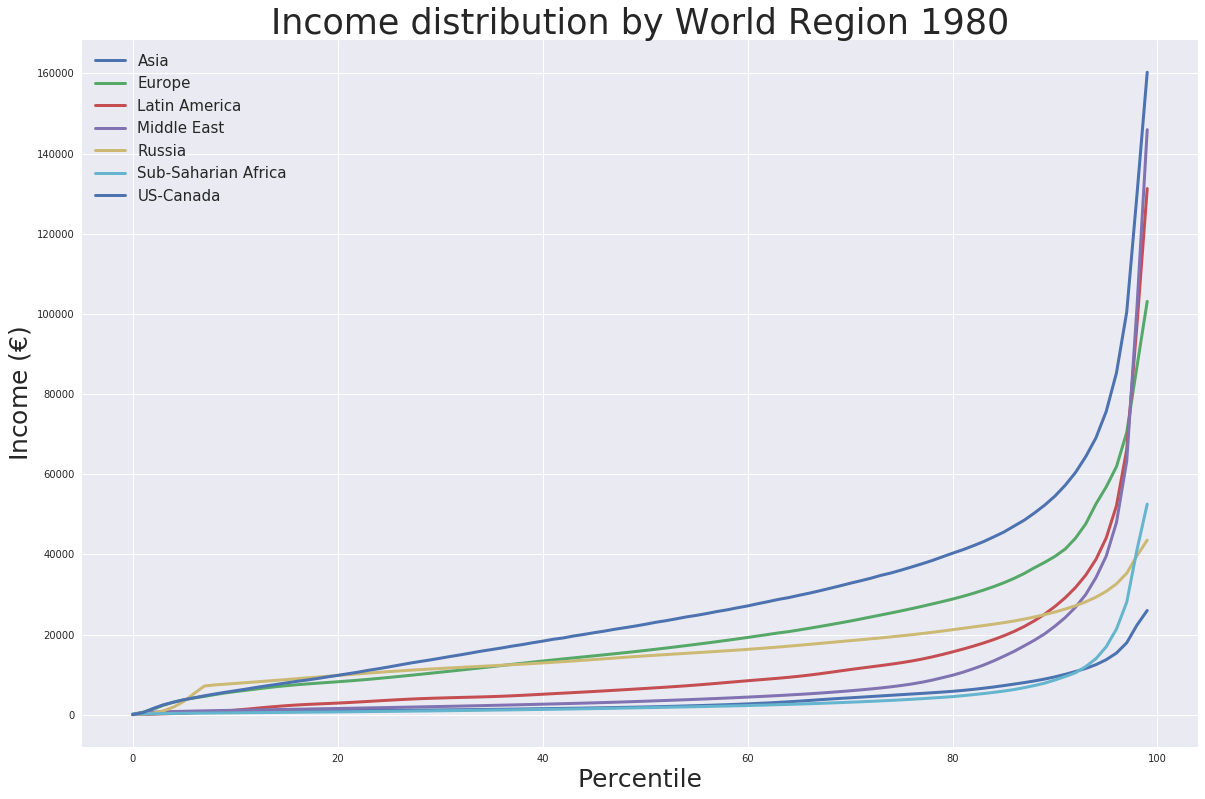

,Top 78/Bottom 22
Asia,22.535291
Europe,15.290133
Latin America,34.731718
Middle East,34.170044
Russia,9.516313
Sub-Saharian Africa,34.512750
US-Canada,19.371188


In [32]:
p =-1
while not int(p) in range(0,100):   #create while loops that allow the user to input desired values for percentle and year 
    print('Percentile has to be in the 1-99 range') #the loop iterate the input bar in case of values out of the range
    p = input("Please select percentile (1-99) : ")
year=0
while not int(year) in range(1980,2017):
    print('Year has to be in the 1980-2016 range')
    year=input('Please choose year from 1980 to 2016:')
bottom_p=[] #initializing two empty lists
top_p=[]   
for chunk in pd.read_csv('data/World.csv',chunksize=100):  #for loop for reading the dataset in chunks
    if (chunk['Year'].iloc[0])==int(year): #if statement to make sure to select the year requested
        x=chunk['Percentile']
        y=chunk['Bracket average']    
        f = interp1d(x, y) #interpolete each chunk's percentiles and incomes to create a distribution function
        k=np.arange(0,100)
        z=f(k) #evaluate the function over the 0-100 range
        bottom_p.append(list(integrate.quad(f,0,int(p), full_output = 1))[0]) #compute the integral of the function from 0 to p, append it to the first empty list(bottom_p)
        top_p.append(list(integrate.quad(f,int(p),99,full_output = 1))[0]) #compute the integral of the function from p to 99, append it to the second empty list (top_p)
        plt.plot(k,z,linewidth=3) #plotting the distribution function for all regions in the selected year
        plt.xlabel('Percentile',fontsize=25)
        plt.ylabel('Income ($€$)',fontsize=25)
        plt.title('Income distribution by World Region '+str(year), fontsize=35)

plt.legend(World.Region.unique(), fontsize=15)
fig = plt.gcf() 
fig.set_size_inches(20, 13) #changing the figure size
plt.show()
ineq_share=np.array(top_p)/np.array(bottom_p) #computing the ratio of the two integrals
pd.DataFrame(ineq_share,index=World.Region.unique(),columns=[('Top '+str(100-int(p))+'/Bottom '+str(p))]) #creating a dataframe that displays the income share for all 7 regions

## Conclusions <a name="Conc"></a>

We investigated income inequality in seven world regions during the last decades. We used three different indexes and income shares to asses whether the gap between rich and poor has widened and whether regional peculiarities are present. All the methods bring us to similar conclusions: in the most developed countries (i.e. Europe, Russia and  North America) inequality has slowly, but steadlity increased. The trend was the opposite for Africa, Middle East and Latin America where societies have moved to a less unequal distribution of wealth. Lastly, the asian region did not score better than the west world, with an increasing trend. Noticeble is the case of Russia, where the end of the communist regime had a disruptive effect on inequality, that peaked right after its collapse. 
But fellows European friends, that's not all bad news. In fact, when comparing in absolute terms inequality across the seven world's regions, Europe is by far the best place to be born in. The same cannot be said of Middle East and Africa: despite moving some steps in the right direction, much has still to be done to reach an equal society.